# Introduction to Probabilistic Modeling

This notebook introduces the probabilistic modeling primitives provided by `fwd_model_tools`. We cover:

1. **Custom distributions for MCMC** — `PreconditionnedUniform` and `ProbitTransform`, which reparameterize bounded parameters into unconstrained Gaussian space for efficient HMC/NUTS sampling.
2. **Sampling initial conditions** — `DistributedNormal` for white noise and `DistributedIC` for directly sampling cosmological density fields with correct power spectrum structure.

These building blocks are used by the full Bayesian inference pipeline in notebook 11.

## Setup

In [14]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro.infer.reparam import TransformReparam
from numpyro.handlers import reparam

import fwd_model_tools as ffi

## 1. Custom Distributions and MCMC

HMC and NUTS samplers work best in unconstrained spaces. When we have bounded parameters (e.g. $\Omega_m \in [0.1, 0.5]$), naively sampling a uniform prior leads to wasted proposals at the boundaries.

`PreconditionnedUniform` solves this by composing two transforms:
- **`ProbitTransform`** — maps $\mathbb{R} \to (0, 1)$ using the standard normal CDF ($\Phi$)
- **`AffineTransform`** — rescales $(0, 1) \to (\text{low}, \text{high})$

The sampler explores an unconstrained Gaussian space (the "base" space), while the model sees uniform samples in the bounded domain.

Let's demonstrate this with a simple 1D model.

In [2]:
def simple_model():
    # Sample x from a preconditioned uniform on [-3, 3]
    # Under the hood, NUTS explores a standard Normal (the "base" space)
    with reparam(config={"x": TransformReparam()}):
        x = numpyro.sample(
            "x",
            ffi.infer.dist.PreconditionnedUniform(low=-3.0, high=3.0),
        )

# Run MCMC
kernel = NUTS(simple_model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=10_000, progress_bar=False)
mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

The MCMC produces three related quantities:

- **`y`** — the observed variable (fixed at 1.0)
- **`x`** — the parameter of interest, living in $[-3, 3]$
- **`x_base`** — the unconstrained Gaussian variable that NUTS actually explores

Let's visualize all three to see the reparameterization in action.

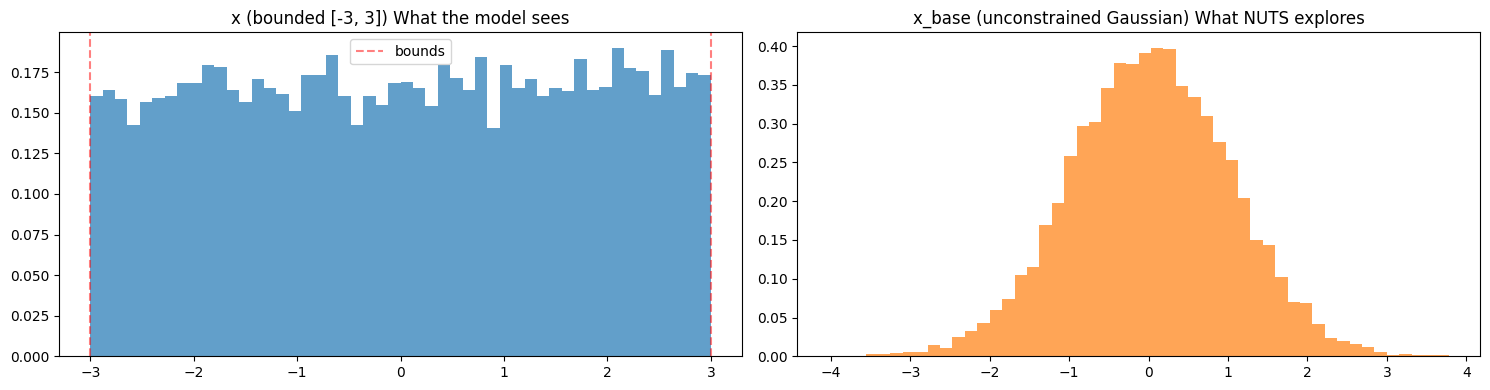

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))


# Final x in bounded space
axes[0].hist(samples["x"], bins=50, density=True, alpha=0.7, color="tab:blue")
axes[0].axvline(-3.0, color="red", linestyle="--", alpha=0.5)
axes[0].axvline(3.0, color="red", linestyle="--", alpha=0.5, label="bounds")
axes[0].set_title("x (bounded [-3, 3]) What the model sees")
axes[0].legend()
# Base space (unconstrained Gaussian)
axes[1].hist(samples["x_base"], bins=50, density=True, alpha=0.7, color="tab:orange")
axes[1].set_title("x_base (unconstrained Gaussian) What NUTS explores")

plt.tight_layout()
plt.show()

## 2. Sampling Initial Conditions

Cosmological initial conditions are Gaussian random fields whose statistics are fully described by the matter power spectrum $P(k)$. We can express this as a generative model:

$$\delta(\mathbf{k}) = \sqrt{P(k)} \cdot \epsilon(\mathbf{k}), \quad \epsilon \sim \mathcal{N}(0, 1)$$

There are two ways to sample ICs in a NumPyro model:

| Approach | Distribution | What it samples | Power spectrum applied by |
|----------|-------------|-----------------|-------------------------|
| Manual | `DistributedNormal` | White noise $\epsilon$ | You call `interpolate_initial_conditions` |
| Reparameterized | `DistributedIC` | Density field $\delta$ directly | Built into the distribution's transform |

In [4]:
# Simulation parameters
mesh_size = (32, 32, 32)
box_size = (250.0, 250.0, 250.0)
cosmo = jc.Planck18()

### Approach 1: Without Reparameterization

Sample white noise from `DistributedNormal(0, 1)`, then manually apply the power spectrum via `interpolate_initial_conditions`. This gives you explicit control over the pipeline stages.

In [5]:
def ic_model_manual():
    """Sample white noise, then apply power spectrum manually."""
    white_noise = numpyro.sample(
        "white_noise",
        ffi.infer.dist.DistributedNormal(
            loc=jnp.zeros(mesh_size),
            scale=jnp.ones(mesh_size),
            mesh_size=mesh_size,
            box_size=box_size,
        ),
    )
    # white_noise is now a DensityField — extract .array for manual interpolation
    field = ffi.interpolate_initial_conditions(
        white_noise.array, mesh_size, box_size, cosmo=cosmo,
    )
    numpyro.deterministic("density_field", field.array)


# Draw one forward sample using Predictive (no MCMC needed)
predictive = Predictive(ic_model_manual, num_samples=1)
key = jax.random.PRNGKey(42)
manual_samples = predictive(key)

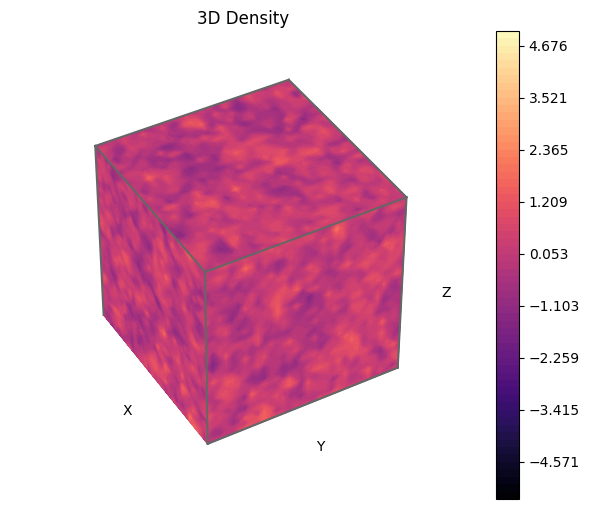

In [6]:
# Wrap the result in a DensityField for visualization
manual_field = ffi.DensityField(
    array=manual_samples["density_field"][0],
    mesh_size=mesh_size,
    box_size=box_size,
    status=ffi.FieldStatus.INITIAL_FIELD,
    unit=ffi.units.DENSITY
)
manual_field.show()

### Approach 2: With Reparameterization

`DistributedIC` is a `TransformedDistribution` that encapsulates the entire IC generation pipeline:
- Base distribution: `DistributedNormal(0, 1)` (white noise)
- Transform: `PowerSpectrumTransform` (FFT-based power spectrum interpolation)

When combined with `TransformReparam`, NUTS explores the white-noise base space while the model works with the physical density field. This is analogous to the `PreconditionnedUniform` example above, but for 3D fields.

In [7]:
def ic_model_reparam():
    """Sample ICs directly via DistributedIC + reparameterization."""
    with reparam(config={"initial_conditions": TransformReparam()}):
        density_field = numpyro.sample(
            "initial_conditions",
            ffi.infer.dist.DistributedIC(box_size=box_size, mesh_size=mesh_size, cosmo=cosmo),
        )

# Draw one forward sample
predictive = Predictive(ic_model_reparam, num_samples=1)
reparam_samples = predictive(jax.random.PRNGKey(42))

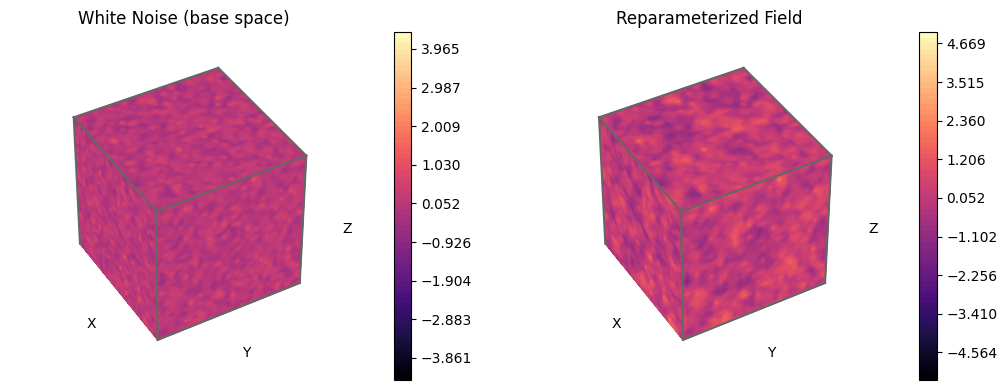

In [8]:
# Samples are now DensityFields — select first sample from the batch dimension
reparam_field = reparam_samples["initial_conditions"].replace(
    array=reparam_samples["initial_conditions"].array[0]
)
white_noise = reparam_samples["initial_conditions_base"].replace(
    array=reparam_samples["initial_conditions_base"].array[0]
)
figure, axes = plt.subplots(1, 2, figsize=(15, 4), subplot_kw={"projection": "3d"})
white_noise.plot(ax=axes[0], titles="White Noise (base space)")
reparam_field.plot(ax=axes[1], titles="Reparameterized Field")
plt.tight_layout()
plt.show()

# Sampling different kinds of fields

You can also sample other types of fields (e.g. lensing convergence) by changing the `field_type` argument in `DistributedNormal`. 
The use case would be sampling the observable for example and this can be done in the following way:


In [9]:
nside = 256
flatsky_npix = (256 , 256)
field_size = (10. , 10.)


def dens_model():
    """Sample ICs directly via DistributedIC + reparameterization."""
    spherical_density = numpyro.sample(
        "spherical_density",
        ffi.infer.dist.DistributedNormal(0.0 , 1.0 , mesh_size=mesh_size, box_size=box_size, field_type="spherical", nside=nside, flatsky_npix=flatsky_npix, field_size=field_size),
    )
    flat_density = numpyro.sample(
        "flat_density",
        ffi.infer.dist.DistributedNormal(0.0 , 1.0 , mesh_size=mesh_size, box_size=box_size, field_type="flat", nside=nside, flatsky_npix=flatsky_npix, field_size=field_size),
    )

    # You can also sample the observable directly with some sigma for the likelihood
    flat_sky = jax.random.normal(jax.random.PRNGKey(0), shape=flatsky_npix) * 0.1 + flat_density.array.mean()
    spherical_map = jax.random.normal(jax.random.PRNGKey(1), shape=(12 * nside**2,)) * 0.1 + spherical_density.array.mean()
    flat_sky = ffi.FlatDensity(array=flat_sky , mesh_size=mesh_size, box_size=box_size , nside=nside, flatsky_npix=flatsky_npix, field_size=field_size)
    spherical_map = ffi.SphericalDensity(array=spherical_map , mesh_size=mesh_size, box_size=box_size, nside=nside, flatsky_npix=flatsky_npix, field_size=field_size)

    numpyro.sample("flat_sky_field", ffi.infer.dist.DistributedNormal(loc=flat_sky , scale=0.3))
    numpyro.sample("spherical_sky_field", ffi.infer.dist.DistributedNormal(loc=spherical_map , scale=0.3))

# Draw one forward sample
predictive = Predictive(dens_model, num_samples=1)
reparam_samples = predictive(jax.random.PRNGKey(42))


/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/lightcone.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_336793/3829010104.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


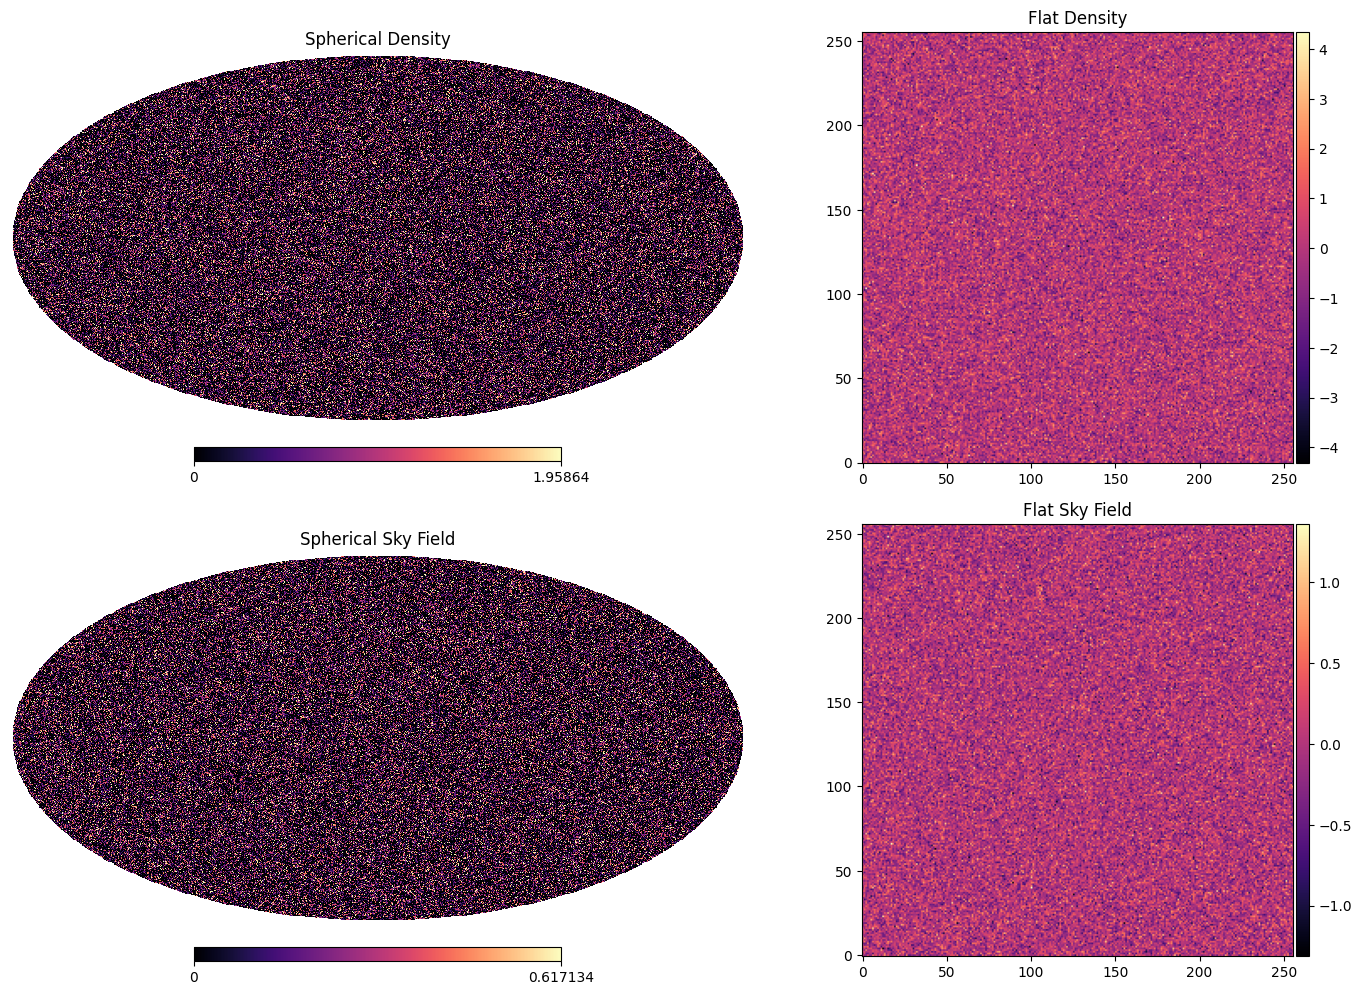

In [10]:

fig , ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()  # Flatten the 2D array of axes for easy indexing
reparam_samples["spherical_density"].plot(ax=ax[0], titles="Spherical Density")
reparam_samples["flat_density"].plot(ax=ax[1], titles="Flat Density")
reparam_samples["spherical_sky_field"].plot(ax=ax[2], titles="Spherical Sky Field")
reparam_samples["flat_sky_field"].plot(ax=ax[3], titles="Flat Sky Field")
plt.tight_layout()
plt.show()

# Using this inside an MCMC model  

A quick head's up: when using these distributions inside a NumPyro model, you must keep in mind that the sampled fields are stripepd from their field information as opposed to what happens when you are using `Predective` so in order to reconstruct the field you can do the following

In [11]:
nside = 256
flatsky_npix = (256 , 256)
field_size = (10. , 10.)


def bad_sph_model():
    """Sample ICs directly via DistributedIC + reparameterization."""
    spherical_density = numpyro.sample(
        "spherical_density",
        ffi.infer.dist.DistributedNormal(0.0 , 1.0 , mesh_size=mesh_size, box_size=box_size, field_type="spherical", nside=nside, flatsky_npix=flatsky_npix, field_size=field_size),
    )

# Draw one forward sample
predictive = Predictive(bad_sph_model, num_samples=1)
reparam_samples = predictive(jax.random.PRNGKey(42))

mcmc = MCMC(NUTS(bad_sph_model), num_warmup=1, num_samples=1)
mcmc.run(jax.random.PRNGKey(0))

samples = mcmc.get_samples()

print(f"Type of samples from predictive: {type(reparam_samples['spherical_density'])}")
print(f"Type of samples from MCMC: {type(samples['spherical_density'])}")

sample: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s, 1 steps of size 4.28e+00. acc. prob=0.00]

Type of samples from predictive: <class 'fwd_model_tools.fields.lightcone.SphericalDensity'>
Type of samples from MCMC: <class 'jaxlib._jax.ArrayImpl'>


So in order to ensure the same behaviour you need to to this

In [12]:
nside = 16
flatsky_npix = (16 , 16)
field_size = (10. , 10.)


def good_sph_model():
    """Sample ICs directly via DistributedIC + reparameterization."""
    spherical_density = numpyro.sample(
        "spherical_density",
        ffi.infer.dist.DistributedNormal(0.0 , 1.0 , mesh_size=mesh_size, box_size=box_size, field_type="spherical", nside=nside, flatsky_npix=flatsky_npix, field_size=field_size),
    )
    if not isinstance(spherical_density, ffi.SphericalDensity):
        spherical_density = ffi.SphericalDensity(
            array=spherical_density,
            mesh_size=mesh_size,
            box_size=box_size,
            nside=nside,)
    numpyro.deterministic("spherical_density_meta_data", spherical_density.to_metadata())
        

# Draw one forward sample
predictive = Predictive(good_sph_model, num_samples=1)
reparam_samples = predictive(jax.random.PRNGKey(42))

mcmc = MCMC(NUTS(good_sph_model), num_warmup=1, num_samples=1)
mcmc.run(jax.random.PRNGKey(0))

samples = mcmc.get_samples()
samples["spherical_density"] = ffi.SphericalDensity.FromDensityMetadata(array=samples["spherical_density"], field=samples["spherical_density_meta_data"])

print(f"Type of samples from predictive: {type(reparam_samples['spherical_density'])}")
print(f"Type of samples from MCMC: {type(samples['spherical_density'])}")

sample: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

Type of samples from predictive: <class 'fwd_model_tools.fields.lightcone.SphericalDensity'>
Type of samples from MCMC: <class 'fwd_model_tools.fields.lightcone.SphericalDensity'>


In [13]:
reparam_samples['spherical_density'].array

Array([[ 0.64989201,  0.11847861, -1.55571939, ...,  0.34087603,
         0.01146993, -0.50372181]], dtype=float64)

# Sharding

`DistributedNormal` and `DistributedIC` support sharding across multiple devices for large 3D fields. You can specify `mesh_size` and `box_size` to control the domain decomposition. The distribution will automatically shard the samples and apply the correct transforms in parallel.
You only need to specify the sharding parameter and the sampled normal will be sharded across the devices. (a 1D sharding will be applied for the spherical fields)

for example 


```python
density_field = numpyro.sample(
            "initial_conditions",
            ffi.infer.dist.DistributedIC(box_size=box_size, mesh_size=mesh_size, cosmo=cosmo, sharding=sharding),
        )
```

Or in case you are samopling the observable directly 

```python
numpyro.sample("kappa", ffi.infer.dist.DistributedNormal(loc=sharded_spherical_map , scale=0.3))
```

The sharding is infered from the field itself and no need to specify it again when sampling the observable.
